In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv("trx-usd-max.csv")
df['snapped_at'] = pd.to_datetime(df['snapped_at'])
df['snapped_at'] = df['snapped_at'].dt.strftime('%Y-%m-%d')
df.head()

,snapped_at,price,market_cap,total_volume
0,2017-11-09,0.002387,1.564042e+08,1.224287e+06
1,2017-11-10,0.002044,1.339685e+08,9.904228e+05
2,2017-11-11,0.001915,1.254706e+08,7.076430e+05
3,2017-11-12,0.001804,1.182352e+08,8.147892e+05
4,2017-11-13,0.002018,1.323864e+08,8.949856e+05


In [6]:
df.tail()

,snapped_at,price,market_cap,total_volume
2417,2024-06-22,0.118295,1.032038e+10,3.377688e+08
2418,2024-06-23,0.119594,1.043394e+10,2.333869e+08
2419,2024-06-24,0.119126,1.039536e+10,2.157735e+08
2420,2024-06-25,0.119138,1.038292e+10,4.013700e+08
2421,2024-06-26,0.121878,1.064070e+10,3.069849e+08


In [7]:
df.describe()

,price,market_cap,total_volume
count,2422.000000,2.422000e+03,2.422000e+03
mean,0.055506,4.529859e+09,8.472917e+08
std,0.034944,3.106280e+09,1.017632e+09
min,0.001804,1.182352e+08,1.649305e+04
25%,0.023866,1.578241e+09,2.659413e+08
50%,0.055444,4.532790e+09,5.401037e+08
75%,0.077016,6.777577e+09,1.105367e+09
max,0.231673,1.523206e+10,1.301873e+10


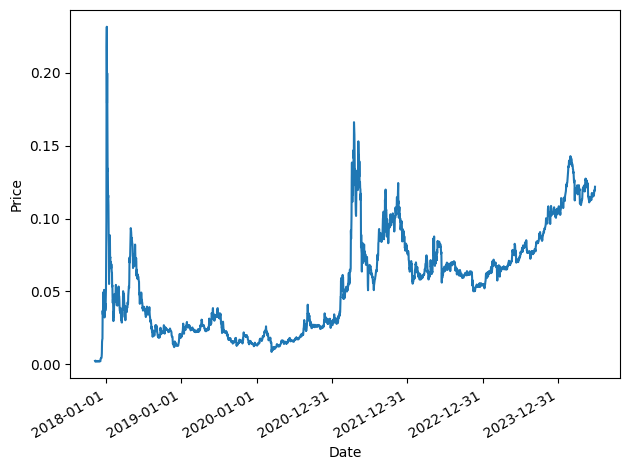

In [9]:
fig, ax = plt.subplots()

ax.plot(df["snapped_at"], df["price"])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
# ax.axvspan(2056, 2421, color='#808080', alpha=0.2)

plt.xticks(np.arange(53, 2421,365))

fig.autofmt_xdate()
plt.tight_layout()

Is this Random Walk?


In [11]:
ADF_result = adfuller(df['price'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.5560854729933182
p-value: 0.10241735339644731


p-value is not less than 0.05 so cannot reject null hypothesis.


so we get difference

In [12]:
diff_price = np.diff(df['price'], n=1)

In [13]:
diff_ADF_result = adfuller(diff_price)

print(f'ADF Statistic: {diff_ADF_result[0]}')
print(f'p-value: {diff_ADF_result[1]}')

ADF Statistic: -10.765182838268961
p-value: 2.4629867112565233e-19


p-value is less than 0.05 so diff_price is stationary.

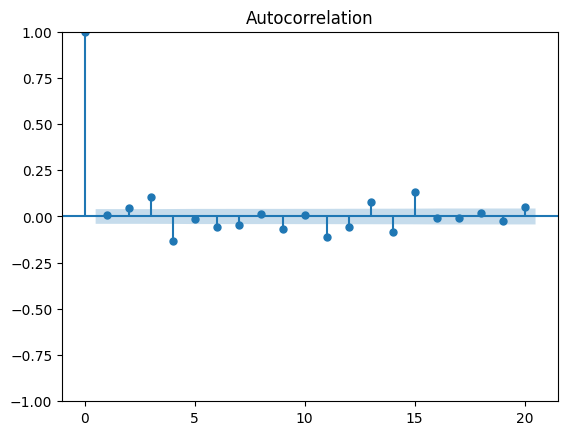

In [27]:
plot_acf(diff_price, lags=20);

Time series is very near to Random Walk. But not 100%